# Temperature prediction using Random Forest decision tree

The random forest algorithm was chosen as the first machine learning method because it is well understood, popular, and the simplest method for training weather forecasting algorithms.

#### 1. Train machine learning

Load prepared train dataset.

In [1]:
import numpy as np
import pandas as pd

In [2]:
train_montreal = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Montreal.csv")

In [3]:
#train_toronto = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Toronto.csv")

In [4]:
#train_dallas = pd.read_csv("C:/PythonGIS/dataanalysis/proj/train_data_Dallas.csv")

In [5]:
train_montreal.isnull().sum()

location              0
Temperature_C         0
Time                  0
Year                  0
Month                 0
Day                   0
id                    0
Humidity_pct          0
Pressure_hPa          0
Wind_Speed_kmh        0
Wind_Direction_deg    0
dtype: int64

No missing values. In next step add hour values to detect diurnal cycle of temperature.

In [6]:
train_montreal["Hour"] = pd.to_datetime(train_montreal["Time"], format="%H:%M:%S").dt.hour


In [7]:
train_montreal

,location,Temperature_C,Time,Year,Month,Day,id,Humidity_pct,Pressure_hPa,Wind_Speed_kmh,Wind_Direction_deg,Hour
0,Montreal,-13.28,00:00:00,2013,1,1,1,78.0,1019.0,25.2,250.0,0
1,Montreal,-14.01,01:00:00,2013,1,1,2,84.0,1020.0,21.6,240.0,1
2,Montreal,-13.84,02:00:00,2013,1,1,3,84.0,1019.0,18.0,240.0,2
3,Montreal,-13.89,03:00:00,2013,1,1,4,84.0,1020.0,18.0,250.0,3
4,Montreal,-13.18,04:00:00,2013,1,1,5,78.0,1020.0,25.2,260.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
35059,Montreal,-11.10,19:00:00,2016,12,31,35060,85.0,1011.0,14.4,40.0,19
35060,Montreal,-11.04,20:00:00,2016,12,31,35061,85.0,1009.0,28.8,30.0,20
35061,Montreal,-11.10,21:00:00,2016,12,31,35062,78.0,1009.0,28.8,30.0,21
35062,Montreal,-11.10,22:00:00,2016,12,31,35063,92.0,1008.0,14.4,30.0,22


Use temperature as target value and other important values for prediction. Add month, day and hour for detecting annual and diurnal cycle patterns.

In [8]:
features = [
    "Humidity_pct",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour"
]

X = train_montreal[features]
y = train_montreal["Temperature_C"]


Split your dataset into 80% of training data and 20% of validation data.

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


Set up a parameters for test prediction.

In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

Evaluate a prediction accuracy.

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("MAE (Montreal):", mae)
print("RMSE (Montreal):", rmse)


MAE (Montreal): 3.3365994190495396
RMSE (Montreal): 4.266079394230637


In [12]:
#MAE (Montreal): 3.3365994190495396
#RMSE (Montreal): 4.266079394230637

In [13]:
#MAE (Toronto): 3.1917426535387454
#RMSE (Toronto): 3.96086492918155

In [14]:
#MAE (Dallas): 2.707684284504991
#RMSE (Dallas): 3.727287949483419

Here it can be seen that mean error or temperature prediction is ~3 °C and roor mean square error is 4 °C. It is quiet big error for normal weather prediction, because difference between -1 °C and 2 °C very significant in real conditions.

Lets see, which parameter has biggest imporance.

In [15]:
import matplotlib.pyplot as plt

In [16]:
importances = model.feature_importances_
print("len(features):", len(features))
print("len(importances):", len(importances))

len(features): 7
len(importances): 7


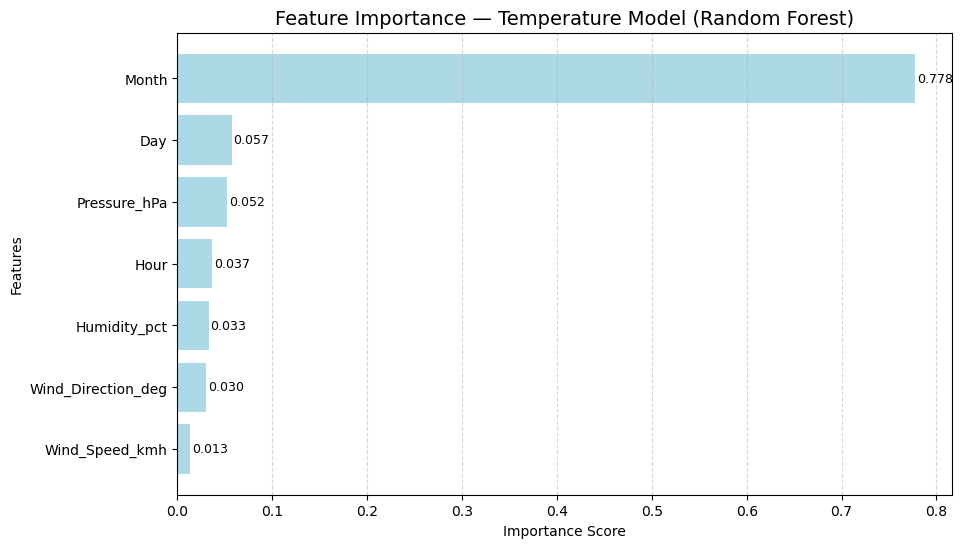

In [17]:
# Convert to array
imp = np.array(importances)

# Sort features by importance (descending)
sorted_idx = np.argsort(imp)
sorted_features = np.array(features)[sorted_idx]
sorted_imp = imp[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_imp, color='lightblue')

# Add numeric value labels
for i, v in enumerate(sorted_imp):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=9)

plt.title("Feature Importance — Temperature Model (Random Forest)", fontsize=14)
#include X-axis label
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

Importance score shows huge importance of "month" parameter. It confirm seasonal patterns of temparature.

#### 2. Prediction with additional parameters

Add lag features as 1-hour, 24-hour cycle, cyclical encoding for month.

In [18]:
train_montreal["Temp_lag1"]  = train_montreal["Temperature_C"].shift(1)
train_montreal["Temp_lag24"] = train_montreal["Temperature_C"].shift(24)


In [19]:
train_montreal["Temp_roll24"] = train_montreal["Temperature_C"].rolling(24).mean()


In [20]:
train_montreal["Month_sin"] = np.sin(2 * np.pi * train_montreal["Month"] / 12)
train_montreal["Month_cos"] = np.cos(2 * np.pi * train_montreal["Month"] / 12)


In [21]:
train_montreal

,location,Temperature_C,Time,Year,Month,Day,id,Humidity_pct,Pressure_hPa,Wind_Speed_kmh,Wind_Direction_deg,Hour,Temp_lag1,Temp_lag24,Temp_roll24,Month_sin,Month_cos
0,Montreal,-13.28,00:00:00,2013,1,1,1,78.0,1019.0,25.2,250.0,0,NaN,NaN,NaN,5.000000e-01,0.866025
1,Montreal,-14.01,01:00:00,2013,1,1,2,84.0,1020.0,21.6,240.0,1,-13.28,NaN,NaN,5.000000e-01,0.866025
2,Montreal,-13.84,02:00:00,2013,1,1,3,84.0,1019.0,18.0,240.0,2,-14.01,NaN,NaN,5.000000e-01,0.866025
3,Montreal,-13.89,03:00:00,2013,1,1,4,84.0,1020.0,18.0,250.0,3,-13.84,NaN,NaN,5.000000e-01,0.866025
4,Montreal,-13.18,04:00:00,2013,1,1,5,78.0,1020.0,25.2,260.0,4,-13.89,NaN,NaN,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,Montreal,-11.10,19:00:00,2016,12,31,35060,85.0,1011.0,14.4,40.0,19,-11.06,-4.69,-10.871667,-2.449294e-16,1.000000
35060,Montreal,-11.04,20:00:00,2016,12,31,35061,85.0,1009.0,28.8,30.0,20,-11.10,-5.65,-11.096250,-2.449294e-16,1.000000
35061,Montreal,-11.10,21:00:00,2016,12,31,35062,78.0,1009.0,28.8,30.0,21,-11.04,-6.37,-11.293333,-2.449294e-16,1.000000
35062,Montreal,-11.10,22:00:00,2016,12,31,35063,92.0,1008.0,14.4,30.0,22,-11.10,-7.00,-11.464167,-2.449294e-16,1.000000


In [22]:
train_montreal = train_montreal.dropna()


Add new parameters into features set

In [23]:
features = [
    "Humidity_pct",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour",
    "Temp_lag1",
    "Temp_lag24",
    "Temp_roll24",
    "Month_sin",
    "Month_cos"
]


In [24]:
X = train_montreal[features]
y = train_montreal["Temperature_C"]


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


Retrain the random forest model.

In [26]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=30,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42
)

model.fit(X_train, y_train)


RandomForestRegressor(max_depth=30, min_samples_leaf=2, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("MAE (Montreal):", mae)
print("RMSE (Montreal):", rmse)


MAE (Montreal): 0.6174085155305484
RMSE (Montreal): 0.9138922109553285


In [28]:
#MAE (Montreal): 0.6174085155305484
#RMSE (Montreal): 0.9138922109553286

In [29]:
#MAE (Toronto): 0.5700232225905029
#RMSE (Toronto): 0.850833818986938

In [30]:
#MAE (Dallas): 0.5714314764888673
#RMSE (Dallas): 0.8601070105763102

Significant improvement of temperature prediction. Lets check importances.

In [31]:
importances = model.feature_importances_
print("len(features):", len(features))
print("len(importances):", len(importances))


len(features): 12
len(importances): 12


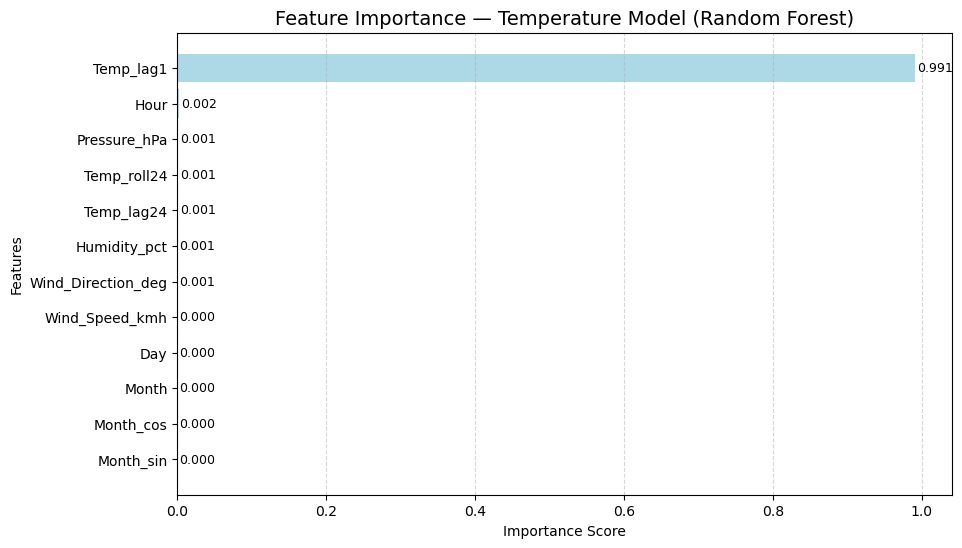

In [32]:
# Convert to array
imp = np.array(importances)

# Sort features by importance (descending)
sorted_idx = np.argsort(imp)
sorted_features = np.array(features)[sorted_idx]
sorted_imp = imp[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_imp, color='lightblue')

# Add numeric value labels
for i, v in enumerate(sorted_imp):
    plt.text(v + 0.002, i, f"{v:.3f}", va='center', fontsize=9)

plt.title("Feature Importance — Temperature Model (Random Forest)", fontsize=14)
#include X-axis label
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()

Here is a very huge importance of 1-hour lag feature. Actually it is logical result, because temperature likely very similar in next hour. It makes prediction easier.

#### 3. Testing random forest model on actual weather data

It is time to test actual weather data prediction. Load test datset.

In [33]:
test_montreal  = pd.read_csv("C:/PythonGIS/dataanalysis/proj/new_test_data/weather_Montreal_2023.csv")

In [34]:
test_montreal["Hour"]  = pd.to_datetime(test_montreal["Time"]).dt.hour

C:\Users\batur\AppData\Local\Temp\ipykernel_13908\3206252853.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_montreal["Hour"]  = pd.to_datetime(test_montreal["Time"]).dt.hour


In [35]:
test_montreal

,Location,Temperature_C,Humidity_pct,Wind_Speed_kmh,Pressure_hPa,Wind_Direction_deg,Time,Year,Month,Day,id,Hour
0,Montreal,2.5,100,10.8,994.4,360,00:00:00,2023,1,1,1,0
1,Montreal,2.6,100,11.2,994.2,6,01:00:00,2023,1,1,2,1
2,Montreal,2.5,100,8.8,994.6,348,02:00:00,2023,1,1,3,2
3,Montreal,2.4,99,7.6,995.1,295,03:00:00,2023,1,1,4,3
4,Montreal,2.4,99,9.9,995.4,280,04:00:00,2023,1,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8755,Montreal,-4.3,64,9.7,1007.4,266,19:00:00,2023,12,31,8756,19
8756,Montreal,-5.3,67,5.2,1007.8,326,20:00:00,2023,12,31,8757,20
8757,Montreal,-5.7,62,12.1,1007.8,12,21:00:00,2023,12,31,8758,21
8758,Montreal,-6.5,60,11.8,1007.8,20,22:00:00,2023,12,31,8759,22


Add same lag features for test dataset.

In [36]:
test_montreal["Temp_lag1"] = test_montreal["Temperature_C"].shift(1)
test_montreal["Temp_lag24"] = test_montreal["Temperature_C"].shift(24)
test_montreal["Temp_roll24"] = test_montreal["Temperature_C"].rolling(24).mean()


In [37]:
test_montreal.isnull().sum()

Location               0
Temperature_C          0
Humidity_pct           0
Wind_Speed_kmh         0
Pressure_hPa           0
Wind_Direction_deg     0
Time                   0
Year                   0
Month                  0
Day                    0
id                     0
Hour                   0
Temp_lag1              1
Temp_lag24            24
Temp_roll24           23
dtype: int64

Here is some missing values, delete them.

In [38]:
for df in [test_montreal]:
    df["Month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["Month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)


In [39]:
test_montreal = test_montreal.dropna().reset_index(drop=True)

In [40]:
features = [
    "Humidity_pct",
    "Pressure_hPa",
    "Wind_Speed_kmh",
    "Wind_Direction_deg",
    "Month",
    "Day",
    "Hour",
    "Temp_lag1",
    "Temp_lag24",
    "Temp_roll24",
    "Month_sin",
    "Month_cos"
]


Predict temperature for 2023 year using trained model earlier.

In [41]:
X_train = train_montreal[features]
y_train = train_montreal["Temperature_C"]

X_test  = test_montreal[features]
y_test  = test_montreal["Temperature_C"]


In [42]:
y_pred = model.predict(X_test)


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("TEST MAE (Montreal 2023):", mae)
print("TEST RMSE (Montreal 2023):", rmse)


TEST MAE (Montreal 2023): 0.854099564764069
TEST RMSE (Montreal 2023): 1.1734394126921988


In [44]:
#TEST MAE (Montreal 2023): 0.8577757267769983
#TEST RMSE (Montreal 2023): 1.176109616931621

In [45]:
#TEST MAE (Toronto 2023): 0.83653781505574
#TEST RMSE (Toronto 2023): 1.1291408086421133

In [46]:
#TEST MAE (Dallas 2023): 1.1981480437050396
#TEST RMSE (Dallas 2023): 1.620676916267892

Temperature prediction was better for Montreal and Toronto than for Dallas. It might be caused by different warmer climate of Dallas city.

Prepare dataset for plot to see the differences of actual and predicted values of temperature during January-March 2023.

In [47]:
test_montreal["Datetime"] = pd.to_datetime(
    test_montreal["Year"].astype(str) + "-" +
    test_montreal["Month"].astype(str) + "-" +
    test_montreal["Day"].astype(str) + " " +
    test_montreal["Time"].astype(str)
)


Add predicted temperature values to test dataset.

In [48]:
test_montreal["Predicted_Temp"] = y_pred


For clarity, it is preferable to see the winter season.

In [49]:
jan_feb_mar = test_montreal[(test_montreal["Month"] == 1) | 
                        (test_montreal["Month"] == 2) | 
                        (test_montreal["Month"] == 3)]

In [50]:
print(jan_feb_mar.shape)


(2136, 19)


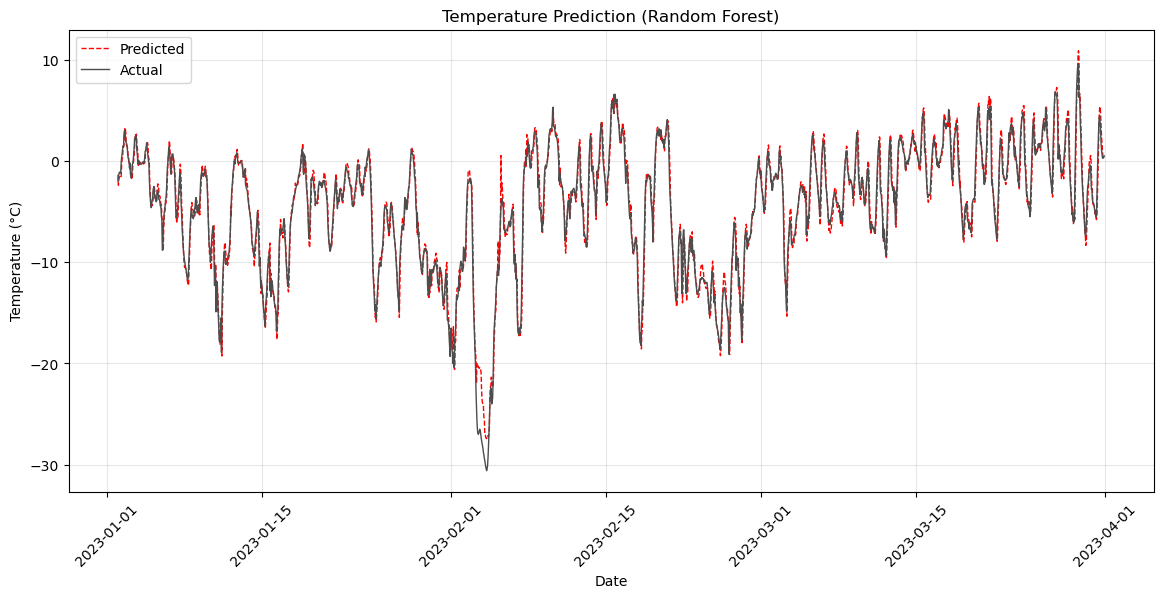

In [51]:
plt.figure(figsize=(14,6))

plt.plot(jan_feb_mar["Datetime"], jan_feb_mar["Predicted_Temp"], 
         label="Predicted", color='red', linewidth=1, linestyle="--")

plt.plot(jan_feb_mar["Datetime"], jan_feb_mar["Temperature_C"], 
         label="Actual", color='#4d4d4d', linewidth=1)

plt.title("Temperature Prediction (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.savefig(
    "C:/PythonGIS/dataanalysis/proj/result/montreal_temp_jan_feb_mar.svg",
    format="svg",
    bbox_inches='tight'
)
plt.show()


**Repeat same Toronto and Dallas dataset.**